In [1]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from statsmodels.tsa.api import Holt, ExponentialSmoothing

## Using saas.csv or log data from API usage

In [2]:
df = pd.read_csv('saas.csv', index_col=0)

In [12]:
df

,Customer_Id,Invoice_Id,Subscription_Type,Amount
Month_Invoiced,,,,
2014-01-31,1000000,5000000,0.0,0.0
2014-01-31,1000001,5000001,2.0,10.0
2014-01-31,1000002,5000002,0.0,0.0
2014-01-31,1000003,5000003,0.0,0.0
2014-01-31,1000004,5000004,1.0,5.0
...,...,...,...,...
2014-01-31,1000295,5000295,0.0,0.0
2014-01-31,1000296,5000296,0.0,0.0
2014-01-31,1000297,5000297,0.0,0.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 790458 entries, 2014-01-31 to 2017-12-31
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Customer_Id        790458 non-null  int64  
 1   Invoice_Id         790458 non-null  int64  
 2   Subscription_Type  790458 non-null  float64
 3   Amount             790458 non-null  float64
dtypes: float64(2), int64(2)
memory usage: 30.2+ MB


In [5]:
# setting index as a datetime object
df.index = pd.to_datetime(df.index)

In [6]:
df.index.min(),df.index.max()

(Timestamp('2014-01-31 00:00:00'), Timestamp('2017-12-31 00:00:00'))

In [123]:
df.index[117070:117072]

DatetimeIndex(['2014-06-30', '2014-07-31'], dtype='datetime64[ns]', name='Month_Invoiced', freq=None)

## 1. Split data (train/test) and resample by any period, except daily, and aggregate using the sum.



In [7]:
# using a percentage based split. 
# 15% validate, 10% test , 75% train
train_size = .70
val_size = .15
test_size = .15
n= df.shape[0]
val_start_index = round(train_size*n)
test_start_index = round((train_size+val_size)*n)
train = df[:val_start_index]
val = df[val_start_index:test_start_index]
test = df[test_start_index:]

In [8]:
train.shape, val.shape, test.shape

((553321, 4), (118568, 4), (118569, 4))

In [9]:
# Date range for train, val, test 
train.index.max(), val.index.max(), test.index.max()

(Timestamp('2016-08-31 00:00:00'),
 Timestamp('2017-04-30 00:00:00'),
 Timestamp('2017-12-31 00:00:00'))

In [10]:
mon_train = train.resample('m').Amount.sum()
mon_val = val.resample('m').Amount.sum()
mon_test = test.resample('m').Amount.sum()

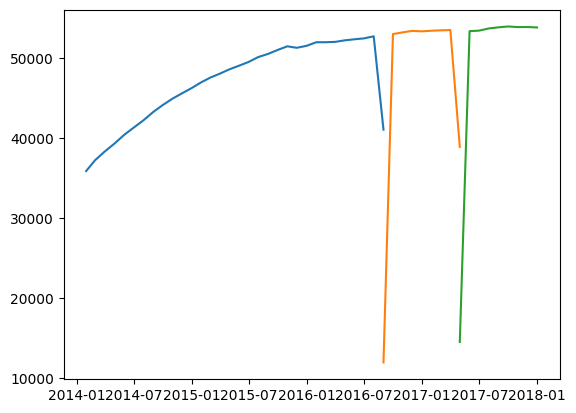

In [11]:
plt.plot(mon_train)
plt.plot(mon_val)
plt.plot(mon_test)
plt.show()

## 2. Forecast, plot and evaluate using each at least 4 of the methods we discussed:
- Last Observed Value
- Simple Average
- Moving Average
- Holt's Linear Trend
- Holt's Seasonal Trend
- Based on previous year/month/etc., this is up to you.

### Last observed value

In [18]:
# using sum of last observed month as a baseline
last_observed = train.resample('m').Amount.sum()[-1]

In [23]:
last_observed

41025.0

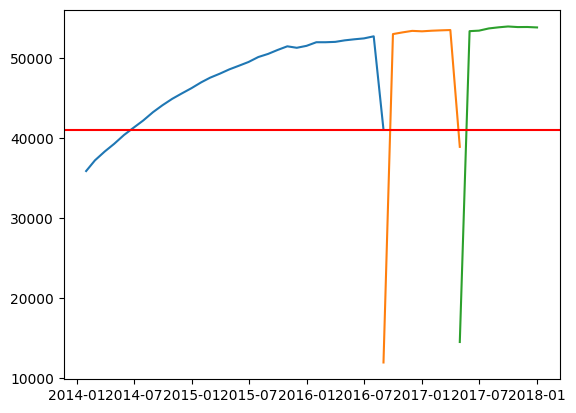

In [22]:
plt.plot(mon_train)
plt.plot(mon_val)
plt.plot(mon_test)
plt.axhline(y=last_observed, color='r')
plt.show()

In [32]:
# using simple average as a baseline. The average of 
simple = train.resample('m').Amount.sum().mean()

In [33]:
simple

46882.03125

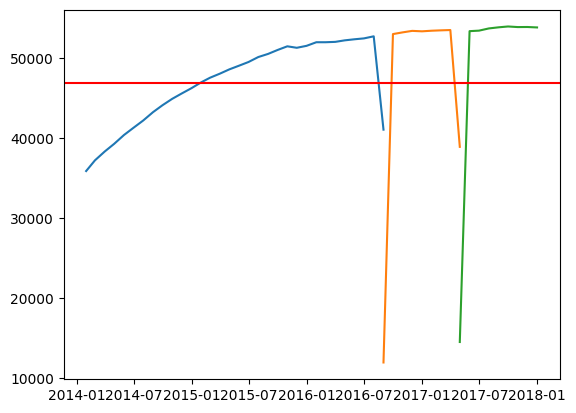

In [34]:
plt.plot(mon_train)
plt.plot(mon_val)
plt.plot(mon_test)
plt.axhline(y=simple, color='r')
plt.show()

In [53]:
# assigning the month sample to a variable because 
# it keeps popping up
# rolling set to 3 months
month = train.resample('m').Amount.sum()
rolling = round(month.rolling(3).mean()[-1], 2)
rolling

48718.33

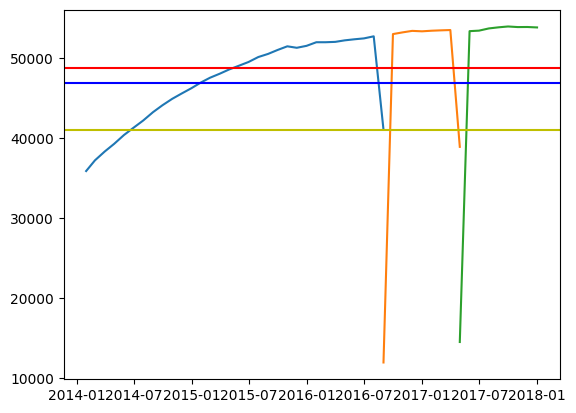

In [41]:
# plot of rolling simple and last observed
plt.plot(mon_train)
plt.plot(mon_val)
plt.plot(mon_test)
plt.axhline(y=rolling, color='r')
plt.axhline(y=simple, color='b')
plt.axhline(y=last_observed, color='y')
plt.show()

### Last observed by far performed the worst. Rolling average by 3 months the best

### Making evaluation metrics

In [57]:
predict = pd.DataFrame({'actual': mon_val,
                      '3_month_rolling': rolling,
                       'simple_avg': simple,
                        'last_observed': last_observed
                       })

In [58]:
predict

,actual,3_month_rolling,simple_avg,last_observed
Month_Invoiced,,,,
2016-08-31,11915.0,48718.33,46882.03125,41025.0
2016-09-30,52975.0,48718.33,46882.03125,41025.0
2016-10-31,53190.0,48718.33,46882.03125,41025.0
2016-11-30,53375.0,48718.33,46882.03125,41025.0
2016-12-31,53320.0,48718.33,46882.03125,41025.0
2017-01-31,53395.0,48718.33,46882.03125,41025.0
2017-02-28,53440.0,48718.33,46882.03125,41025.0
2017-03-31,53480.0,48718.33,46882.03125,41025.0
2017-04-30,38875.0,48718.33,46882.03125,41025.0


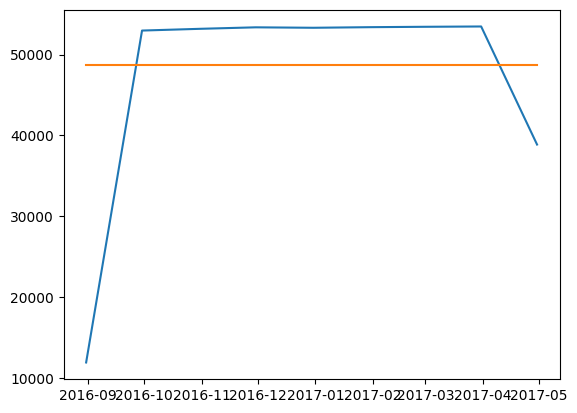

In [60]:
plt.plot(predict.actual)
plt.plot(predict['3_month_rolling'])

### Making a Holt linear model

In [65]:
# making model
model = Holt(month, damped_trend=True).fit()

In [64]:
def eval_preds(df, predictions, actual='actual'):
    
    return round(sqrt(mean_squared_error(df[actual], df[predictions])), 2)

In [75]:
# predicting on validate
forecast = model.forecast(steps=len(mon_val))

In [74]:
# assinging predicted column to predict df
predict['holt'] = forecast

In [76]:
predict

,actual,3_month_rolling,simple_avg,last_observed,holt
Month_Invoiced,,,,,
2016-08-31,11915.0,48718.33,46882.03125,41025.0,NaN
2016-09-30,52975.0,48718.33,46882.03125,41025.0,45695.362793
2016-10-31,53190.0,48718.33,46882.03125,41025.0,43704.245406
2016-11-30,53375.0,48718.33,46882.03125,41025.0,41733.039193
2016-12-31,53320.0,48718.33,46882.03125,41025.0,39781.545042
2017-01-31,53395.0,48718.33,46882.03125,41025.0,37849.565833
2017-02-28,53440.0,48718.33,46882.03125,41025.0,35936.906416
2017-03-31,53480.0,48718.33,46882.03125,41025.0,34043.373593
2017-04-30,38875.0,48718.33,46882.03125,41025.0,32168.776098


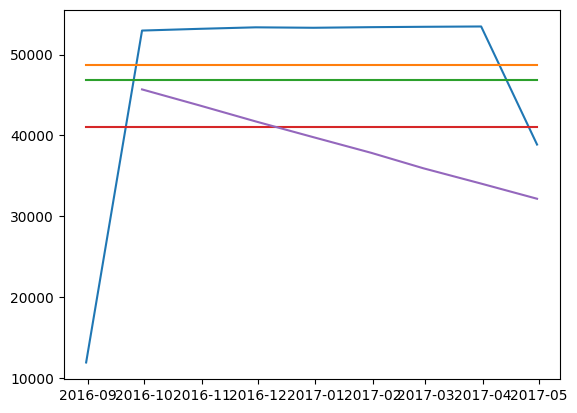

In [80]:
plt.plot(predict.actual)
plt.plot(predict['3_month_rolling'])
plt.plot(predict.simple_avg)
plt.plot(predict.last_observed)
plt.plot(predict.holt)
plt.show()

In [84]:
def eval_preds(df, predictions, actual='actual'):
    
    return round(sqrt(mean_squared_error(df[actual], df[predictions])), 2)

In [83]:
# creating a dataframe to hold my rsme for 
# models and baselines off train
resids = pd.DataFrame()

In [85]:
# gets the RMSE for all columns in the predict dataframe
# adds them to the resids dataframe
for i in predict:
    resids[i] = eval_preds(predict,i,actual='actual')

ValueError: Input contains NaN.